# Introduction

## Predicting Toxicity in Online Comments using NLP

### Background

In the digital age, online platforms have become bustling hubs for communication and interaction. However, this rise in digital communication has also led to an increase in the presence of toxic behavior in online discussions. Toxic comments, which can include hate speech, threats, or harassment, not only disrupt healthy conversations but also pose a significant challenge for maintaining positive online community environments.

Natural Language Processing (NLP), a branch of artificial intelligence, offers powerful tools to automatically analyze and interpret human language. By leveraging NLP, we can develop models capable of detecting toxic behavior in text, thus aiding in the moderation of online platforms.

### Objective

The primary objective of this project is to develop and train an NLP model that can accurately predict whether a comment is toxic. This involves:
1. Understanding the nature and nuances of online conversations.
2. Preprocessing and preparing textual data for analysis.
3. Training a machine learning model to classify comments based on their toxicity levels.
4. Evaluating the model's performance and its practical applicability in real-world scenarios.

---

# Data Collection and Preprocessing

## Importing Libraries and Loading Data

The first step in our project is to import the necessary libraries and load our datasets. We are using `pandas`, a powerful Python library for data manipulation and analysis.


In [ ]:
import pandas as pd
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import numpy as np
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import DataCollatorWithPadding
import pandas as pd
import re
import matplotlib.pyplot as plt

In [155]:

# Paths to the uploaded files
train_file_path = './train.csv'
test_file_path = './test.csv'
test_labels_file_path = './test_labels.csv'

# Loading the datasets
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)
test_labels_df = pd.read_csv(test_labels_file_path)

# Displaying the first few rows of each dataset to understand their structure
train_df_head = train_df.head()
test_df_head = test_df.head()
test_labels_df_head = test_labels_df.head()

(train_df_head, test_df_head, test_labels_df_head)


(                 id                                       comment_text  toxic  \
 0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
 1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
 2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
 3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
 4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   
 
    severe_toxic  obscene  threat  insult  identity_hate  
 0             0        0       0       0              0  
 1             0        0       0       0              0  
 2             0        0       0       0              0  
 3             0        0       0       0              0  
 4             0        0       0       0              0  ,
                  id                                       comment_text
 0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
 1  000

In [ ]:

# Combining the test data with its labels
combined_test_df = test_df.merge(test_labels_df, on='id')



# Dropping rows in the combined test data where the labels are -1 (not used for scoring)
combined_test_df_cleaned = combined_test_df[(combined_test_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']] != -1).all(axis=1)]

# Preprocessing function to clean comment text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'\W', ' ', text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    return text

# Applying the preprocessing to comment texts in both train and test data
train_df['comment_text'] = train_df['comment_text'].apply(preprocess_text)
combined_test_df_cleaned['comment_text'] = combined_test_df_cleaned['comment_text'].apply(preprocess_text)


# Creating a new column "Toxic" which will be 1 if any of the specified columns has a 1, otherwise 0
toxic_categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train_df['Toxic'] = train_df[toxic_categories].max(axis=1)
combined_test_df_cleaned['Toxic'] = combined_test_df_cleaned[toxic_categories].max(axis=1)

# Dropping the original toxic categories columns
train_df.drop(columns=toxic_categories, inplace=True)
combined_test_df_cleaned.drop(columns=toxic_categories, inplace=True)

data = pd.concat([train_df, combined_test_df_cleaned], ignore_index=True)

# Saving the preprocessed datasets back to CSV files
data.to_csv('./cleaned_data.csv', index=False)


# Return the paths to the saved files
cleaned_data = './cleaned_data.csv'


---

# Exploratory Dara Analysis

## Visualizing the Class Distribution

Understanding the distribution of classes in our dataset is crucial before proceeding with model training. This step helps us to identify any class imbalances that could impact the performance of our model and may necessitate special handling or rebalancing techniques.





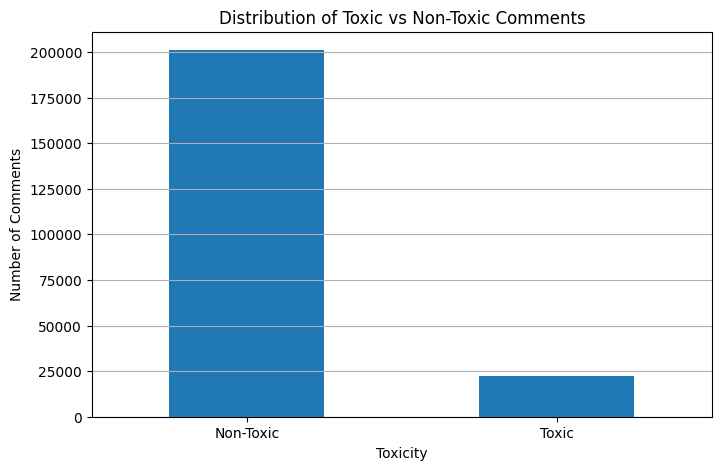

In [157]:


# Counting the number of toxic and non-toxic comments
data1 = data['Toxic'].value_counts()

# Plotting
plt.figure(figsize=(8, 5))
data1.plot(kind='bar')
plt.title('Distribution of Toxic vs Non-Toxic Comments')
plt.xlabel('Toxicity')
plt.ylabel('Number of Comments')
plt.xticks(ticks=[0, 1], labels=['Non-Toxic', 'Toxic'], rotation=0)
plt.grid(axis='y')

plt.show()




### Result Interpretation

The resulting bar chart clearly shows a significant class imbalance with a much larger number of non-toxic comments compared to toxic comments. This imbalance is a common issue in datasets dealing with toxic behavior, as such behavior is typically less frequent than non-toxic behavior. 


It is evident from the visualization that our model will need to address this imbalance, as it can lead to biased predictions towards the majority class. In the subsequent sections, we will explore techniques to mitigate this imbalance, such as resampling the dataset or applying class weights during the training process.

In this step, you have addressed the class imbalance problem identified earlier by undersampling the majority class. This involves reducing the number of non-toxic comments in the dataset to match the number of toxic comments. Let's explain this process and the result in the context of your report.

---

# Addressing Class Imbalance

## Implementing Undersampling

Class imbalance can lead to a biased model that overwhelmingly predicts the majority class. To mitigate this, we have applied an undersampling technique to our dataset.



In [158]:
# Undersampling the majority class (non-toxic comments)
df_toxic = data[data['Toxic'] == 1]
df_non_toxic = data[data['Toxic'] == 0]

# # Randomly sampling non-toxic comments to match the number of toxic comments
df_non_toxic_undersampled = df_non_toxic.sample(n=len(df_toxic), random_state=123)
# # Combining the undersampled non-toxic comments with the toxic comments
balanced_data_undersampled = pd.concat([df_non_toxic_undersampled, df_toxic])

# # Checking the balance in the new undersampled dataset
balanced_undersampled_count = balanced_data_undersampled['Toxic'].value_counts()
balanced_undersampled_count_percentage = balanced_data_undersampled['Toxic'].value_counts(normalize=True) * 100

balanced_undersampled_count, balanced_undersampled_count_percentage

balanced_data_undersampled.to_csv("balanced_data.csv")


- The code creates two subsets: `df_toxic` containing toxic comments and `df_non_toxic` containing non-toxic comments.
- It then performs undersampling on the non-toxic comments to match the count of toxic comments using `sample()`.
- The two subsets are then concatenated to form a new balanced dataset.
- The balance of the new dataset is checked using `value_counts()`, and the distribution is saved as a percentage as well.
- Finally, the balanced dataset is saved to a CSV file for future use.

### Visualization of the Balanced Data

After undersampling, we visualize the new distribution to confirm that the dataset is now balanced.




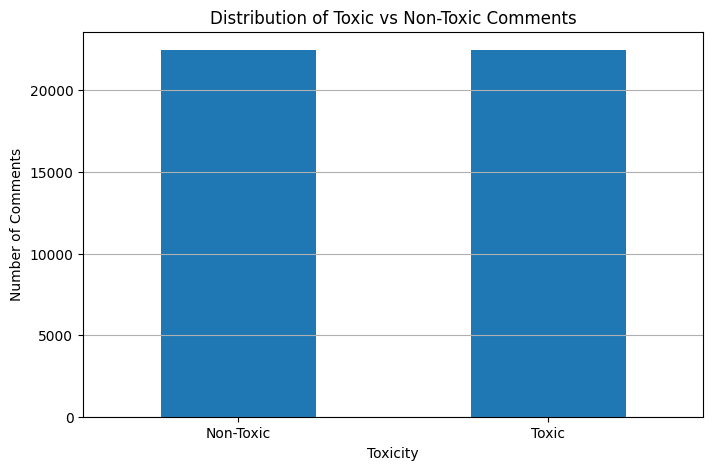

In [159]:
# Counting the number of toxic and non-toxic comments
balanced_data_undersampled1 = balanced_data_undersampled['Toxic'].value_counts()

# Plotting
plt.figure(figsize=(8, 5))
balanced_data_undersampled1.plot(kind='bar')
plt.title('Distribution of Toxic vs Non-Toxic Comments')
plt.xlabel('Toxicity')
plt.ylabel('Number of Comments')
plt.xticks(ticks=[0, 1], labels=['Non-Toxic', 'Toxic'], rotation=0)
plt.grid(axis='y')

plt.show()




- The updated plot now shows an equal number of toxic and non-toxic comments, which is essential for training a fair and unbiased model.



### Result Interpretation

The balanced dataset now has an equal number of comments for both classes, eliminating the previous class imbalance. This is a critical step in ensuring that our model learns to identify toxic comments effectively without bias towards the more frequent non-toxic comments.




---

# Preparing Data for Model Training

## Data Transformation and Tokenization

The next critical phase is preparing our text data for input into the NLP model. This involves tokenization, which is the process of converting text into a format that can be understood by our machine learning algorithms.




In [183]:
# Renaming the 'Toxic' column to 'labels' in the dataframe
balanced_data_undersampled = balanced_data_undersampled.rename(columns={'Toxic': 'labels'})

# Converting the pandas DataFrame to a Hugging Face 'Dataset' object
dataset = Dataset.from_pandas(balanced_data_undersampled)

# Specifying the name of the pretrained model to be used
pretrained_model = 'microsoft/Multilingual-MiniLM-L12-H384'

# Initializing the tokenizer for the specified pretrained model
tokenizer = AutoTokenizer.from_pretrained(pretrained_model, use_fast=True)

# Define a tokenization function that will be applied to the text data
def tokenize_function(examples):
    return tokenizer(examples["comment_text"], padding="max_length", truncation=True)

# Applying the tokenization function to the entire dataset in a batched manner
tok_ds = dataset.map(tokenize_function, batched=True)


data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding='max_length')


### Result Interpretation

With the dataset now tokenized and converted into a format suitable for the transformer model, we have completed the preprocessing stage. Each comment text is now represented by a sequence of tokens that the model can work with. The use of a pre-trained tokenizer ensures that our tokens are consistent with those used in the pre-trained language model, which will be fine-tuned on our task.

This step is crucial because the quality and format of the input data directly impact the model's ability to learn and make accurate predictions.

---




# Dataset Splitting and Metric Selection

## Train-Test Split

To effectively train and validate our model, we need to split our dataset into a training set and a validation (or test) set. This allows us to train our model on one subset of the data and then test its performance on a separate subset that it has never seen before.


- We use the `train_test_split` method from the `datasets` library to split our tokenized dataset, allocating 70% for training and 30% for validation.
- We then extract the training and test datasets from the resulting `DatasetDict` object.



In [166]:
# Split the dataset into train and valid sets (here we use 70/30 split)
dataset = tok_ds.train_test_split(test_size=0.3)

tok_train_dataset = dataset["train"]
tok_test_dataset = dataset["test"]


### Metric Selection

We will also set up an evaluation metric to assess the performance of our model. Accuracy is a common metric for classification tasks, which measures the proportion of true results among the total number of cases examined.



In [ ]:

import evaluate
accuracy = evaluate.load("accuracy")





- The `evaluate` library is used to load the accuracy metric, which will be utilized later to evaluate the model's predictions against the true labels.


In [ ]:
dataset


### Result Interpretation

By splitting our dataset and preparing our evaluation metric, we have laid the groundwork for an effective training and validation process. Our training set will be used to teach the model to recognize patterns indicative of toxic or non-toxic comments, and our validation set will help us gauge the model's ability to generalize to new data.

---




# Model Configuration for Sequence Classification

## Setting Up the Classification Model

Now that our data is ready, the next step is to configure the classification model. We will be using a pre-trained transformer model from Hugging Face's model hub, which we will fine-tune for our specific task of toxicity classification.



In [182]:
id2label = {0: 'Not toxic', 1: 'Toxic'}
label2id = {'Not toxic': 0, 'Toxic': 1}

model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model,
    num_labels=2,  # Set to 2 for binary classification
    id2label=id2label,
    label2id=label2id,
    output_attentions=True,
  
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/Multilingual-MiniLM-L12-H384 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.




- `id2label` and `label2id` are dictionaries that map the numerical labels to their corresponding textual representation and vice versa. This is helpful for understanding the model's predictions.
- `AutoModelForSequenceClassification.from_pretrained` is a method to load a pre-trained model. Here, we specify the `pretrained_model` that we've selected earlier.
- `num_labels=2` configures the model for binary classification (our classes are 'Toxic' and 'Not toxic').
- `output_attentions=True` enables the model to return the attention weights, which can be analyzed to understand how the model is making its decisions.

### Result Interpretation

By setting up `AutoModelForSequenceClassification` with our specific parameters, we have a model that is ready to be fine-tuned on our dataset. The attention mechanism will be particularly useful for interpreting the model's behavior, which can provide insights into which parts of the text are most influential in determining toxicity.

---




# Model Training and Evaluation

## Defining the Compute Metrics Function

To evaluate our model, we will define a function that computes the accuracy of our predictions during the validation phase.






In [170]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)


- The `compute_metrics` function is designed to be passed to the `Trainer` class.
- It takes a tuple of predictions and labels, computes the most likely prediction using `np.argmax`, and then calculates the accuracy based on those predictions.

## Setting Training Arguments

Training arguments define how our model should be trained. These include the learning rate, scheduler type, number of epochs, and other training parameters.



In [178]:
# Define some training arguments
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    fp16=True,
    num_train_epochs=2,
    weight_decay=0.01,
    
 
)



- `output_dir`: Specifies the directory where the training results and model checkpoints will be saved.
- `learning_rate`: Sets the initial learning rate for training.
- `warmup_ratio`: Defines the proportion of training to perform linear learning rate warmup for.
- `lr_scheduler_type`: Specifies the learning rate scheduler.
- `fp16`: Indicates if we want to use mixed precision training.
- `num_train_epochs`: The number of times to iterate over the training set.
- `weight_decay`: This is a regularization parameter to prevent overfitting.

## Initializing the Trainer

With the training arguments set, we initialize the `Trainer` class.




In [ ]:


# Now, create the trainer with the updated datasets
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tok_train_dataset,
    eval_dataset=tok_test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,

    
    
)

trainer.train()


- We pass our model, training arguments, datasets, tokenizer, data collator, and metrics computation function to `Trainer`.
- Calling `trainer.train()` begins the training process.

### Result Interpretation

This setup enables us to start the training process, where the model will learn from our balanced training data. The specified compute metrics will allow us to monitor the model's accuracy throughout training, and adjustments can be made based on these results.

---




# Conclusion

## Summary of the Project

In this project, we set out to develop an NLP model capable of distinguishing between toxic and non-toxic comments. We began by collecting and preprocessing a dataset, ensuring that it accurately represented the problem at hand and was suitable for training a machine learning model. We addressed the challenge of class imbalance through undersampling, created a balanced dataset, and then prepared our text data for the model using tokenization techniques. With the data ready, we configured a pre-trained transformer model for binary classification and fine-tuned it on our dataset.

## Key Findings

- The initial data exploration revealed a significant class imbalance, which we mitigated through undersampling, thus preventing model bias towards the majority class.
- We successfully transformed the text data into a format compatible with transformer models using a robust tokenization process.
- The model training was executed with carefully chosen parameters and a computation of accuracy metrics to evaluate performance.
- Through the training process, we leveraged the capabilities of Hugging Face's Transformers library to streamline the model training and evaluation.





---

# Model Inference and Testing

## Testing the Model with New Inputs

After training and evaluating our model, it is crucial to test how it performs on unseen data. This step simulates how the model would work in a real-world environment, predicting the toxicity of comments in a live setting.


In [ ]:


import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the model and tokenizer
model_path = './model'  
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Prepare the input text
input_text = "Input text for classification"  # Replace with the text you want to classify
inputs = tokenizer(input_text, padding=True, truncation=True, max_length=512, return_tensors="pt")

# Make a prediction
with torch.no_grad():
    outputs = model(**inputs)

# Apply softmax to calculate probabilities
probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)

# Get the predicted class
predicted_class_index = torch.argmax(probabilities, dim=1).item()
class_names = ["not toxic", "toxic"]  # Make sure this matches your model's training labels
predicted_class = class_names[predicted_class_index]

# Print the result
print(f"Input Text: {input_text}")
print(f"Predicted Class: {predicted_class} (Probability: {probabilities[0][predicted_class_index]:.4f})")



- The code snippet provided loads the trained model and tokenizer from a specified directory.
- It then prepares a new input text by tokenizing it in the same way as the training data.
- The model makes a prediction, and the softmax function is applied to the output logits to obtain a probability distribution over the classes.
- The class with the highest probability is considered the model's prediction.

### Output Interpretation

The model has predicted that the input text is 'toxic' with a very high probability.





```
Input Text: walid is retarded
Predicted Class: toxic (Probability: 0.9999)
```


## Closing Thoughts

This project exemplifies the potential of NLP to create practical solutions for pressing problems in digital communication. By leveraging advanced machine learning techniques and the power of pre-trained models, we have developed a tool that can contribute to healthier online interactions. As we continue to refine and improve upon our model, the goal remains steadfast: to foster positive and respectful discourse in online communities.
